# Mixed-precision quantization of SpeechBrain Wav2Vec2 on GPU


This notebook provides code for mixed-precision quantization of the speechbrain/asr-wav2vec2-commonvoice-en model. We compare base model and different mixed-precision quantized models on the timit_asr dataset.

First, let's install `datasets`,  `transformers` and `librosa`.

In [1]:
# %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [2]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [5]:
! pip install --upgrade tensorrt

## Prepare Data, Tokenizer, Feature Extractor

In [6]:
from datasets import load_dataset, load_metric
timit = load_dataset("timit_asr")

Reusing dataset timit_asr (/home/kmb85/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

We normalize the text to only have lower case letters and append a word separator token at the end.

In [8]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [9]:
timit = timit.map(remove_special_characters)

Parameter 'function'=<function remove_special_characters at 0x7fa2d11c9b40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.

In [10]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [11]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [12]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [13]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

We also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm.

In [14]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [15]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

Let's now save the vocabulary as a json file.

In [16]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [17]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [18]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [19]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Let's apply the data preparation function to all examples.

In [20]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

In [22]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

## Base Model

In [23]:
from speechbrain.pretrained import EncoderDecoderASR

torchvision is not available - cannot save figures


In [ ]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [ ]:
torch.onnx.export(asr_model.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Mixed-precision Quantization

In [37]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [ ]:
eight_bits_all_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})
four_bits_all_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})
four_bits_input_eight_bits_weight_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})
eight_bits_input_four_bits_weight_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [39]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
eight_bits_all_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [41]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=4, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
four_bits_all_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [43]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
four_bits_input_eight_bits_weight_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [45]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=4, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
eight_bits_input_four_bits_weight_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [47]:
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [48]:
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [49]:
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [50]:
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [51]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))
            _ = four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))
            _ = four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))
            _ = eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))


In [52]:
# Finalize calibration

eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

eight_bits_all_model_full_quantized.cuda()

W1223 17:45:55.141086 140338919350272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1223 17:45:55.141696 140338919350272 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1223 17:45:55.142235 140338919350272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderDecoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0088, 0.6672](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_qu

In [53]:
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

four_bits_all_model_full_quantized.cuda()

W1223 17:45:55.154783 140338919350272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1223 17:45:55.155329 140338919350272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderDecoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(4bit fake axis=0 amax=[0.0088, 0.6672](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_qu

In [54]:
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

four_bits_input_eight_bits_weight_model_full_quantized.cuda()

W1223 17:45:55.167357 140338919350272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1223 17:45:55.167892 140338919350272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderDecoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0088, 0.6672](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_qu

In [55]:
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

eight_bits_input_four_bits_weight_model_full_quantized.cuda()

W1223 17:45:55.179862 140338919350272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1223 17:45:55.180411 140338919350272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderDecoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(4bit fake axis=0 amax=[0.0088, 0.6672](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_qu

In [57]:
eight_bits_all_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv
four_bits_all_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv
four_bits_input_eight_bits_weight_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv
eight_bits_input_four_bits_weight_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv

In [ ]:
torch.onnx.export(eight_bits_all_model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder-eight_bits_all_model_quantized.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [ ]:
torch.onnx.export(four_bits_all_model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder-four_bits_all_model_quantized.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [ ]:
torch.onnx.export(four_bits_input_eight_bits_weight_model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder-four_bits_input_eight_bits_weight_model_quantized.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [ ]:
torch.onnx.export(eight_bits_input_four_bits_weight_model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder-eight_bits_input_four_bits_weight_model_quantized.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Model Inference Time

In this section, we compare the inference time of the base model and the quantized model on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [ ]:
! pip install onnxruntime-gpu

In [75]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [ ]:
# Load onnx models
ort_sess_eight_bits_all_model_quantized = ort.InferenceSession('asr-wav2vec2-encoder-eight_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_all_model_quantized = ort.InferenceSession('asr-wav2vec2-encoder-four_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_input_eight_bits_weight_model_quantized = ort.InferenceSession('asr-wav2vec2-encoder-four_bits_input_eight_bits_weight_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_eight_bits_input_four_bits_weight_model_quantized = ort.InferenceSession('asr-wav2vec2-encoder-eight_bits_input_four_bits_weight_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('asr-wav2vec2-encoder.onnx')

In [77]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in timit["test"].select(range(num_samples)):
            input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [78]:
num_samples = 50

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [79]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.14773786 seconds


In [88]:
ort_sess_eight_bits_all_model_quantized_time = compute_inference_time(ort_sess_eight_bits_all_model_quantized, num_samples)

In [89]:
print(f'Quantized Model, all layers with 8 bits, inference time {ort_sess_eight_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 8 bits, inference time 0.01155021 seconds


In [90]:
ort_sess_four_bits_all_model_quantized_time = compute_inference_time(ort_sess_four_bits_all_model_quantized, num_samples)

In [91]:
print(f'Quantized Model, all layers with 4 bits, inference time {ort_sess_four_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 4 bits, inference time 0.01121624 seconds


In [92]:
ort_sess_four_bits_input_eight_bits_weight_model_quantized_time = compute_inference_time(ort_sess_four_bits_input_eight_bits_weight_model_quantized, num_samples)

In [93]:
print(f'Quantized Model, 4 bits input and 8 bits weights, inference time {ort_sess_four_bits_input_eight_bits_weight_model_quantized_time} seconds')

Quantized Model, 4 bits input and 8 bits weights, inference time 0.01124431 seconds


In [94]:
ort_sess_eight_bits_input_four_bits_weight_model_quantized_time = compute_inference_time(ort_sess_eight_bits_input_four_bits_weight_model_quantized, num_samples)

In [95]:
print(f'Quantized Model, 8 bits input and 4 bits weights, inference time {ort_sess_eight_bits_input_four_bits_weight_model_quantized_time} seconds')

Quantized Model, 8 bits input and 4 bits weights, inference time 0.01120223 seconds


**Inference Time Visualisation of Results**

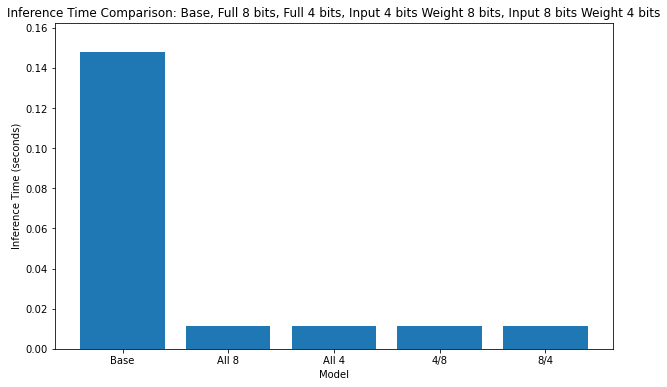

In [96]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_model_time, ort_sess_eight_bits_all_model_quantized_time, ort_sess_four_bits_all_model_quantized_time, ort_sess_four_bits_input_eight_bits_weight_model_quantized_time, ort_sess_eight_bits_input_four_bits_weight_model_quantized_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base, Full 8 bits, Full 4 bits, Input 4 bits Weight 8 bits, Input 8 bits Weight 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

**Evaluating WER metric**

In [30]:
wer_metric = load_metric("wer")

In [31]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model(input_values, torch.tensor([1.0]).to('cuda'))

    pred_str = [' '.join(prediction[0]).lower()]
    correct_str = processor.batch_decode(single_batch['labels'], group_tokens=False)
    return wer_metric.compute(predictions=pred_str, references=correct_str)

In [64]:
num_samples = 500

In [35]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, timit['test'][i:i+1])

base_wer_result = round(total_wer / num_samples, 8)

2023-12-23 17:35:18.368748: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 17:35:18.368793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 17:35:18.368820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 17:35:18.376105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 17:35:19.120482: W tensorflow/compiler/

In [36]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.10934624


In [58]:
asr_model.mods.encoder.wav2vec2.model = eight_bits_all_model_quantized.mods.encoder.wav2vec2.model

In [65]:
total_wer_eight_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_eight_bits_all_model_quantized += map_model_to_wer_result(asr_model, timit['test'][i:i+1])

eight_bits_all_model_quantized_wer_result = round(total_wer_eight_bits_all_model_quantized / num_samples, 8)

In [66]:
print(f'Quantized Model, all layers with 8 bits, WER: {eight_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 8 bits, WER: 0.1161516


In [67]:
asr_model.mods.encoder.wav2vec2.model = four_bits_all_model_quantized.mods.encoder.wav2vec2.model

In [68]:
total_wer_four_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_four_bits_all_model_quantized += map_model_to_wer_result(asr_model, timit['test'][i:i+1])

total_wer_four_bits_all_model_quantized_wer_result = round(total_wer_four_bits_all_model_quantized / num_samples, 8)

In [69]:
print(f'Quantized Model, all layers with 4 bits, WER: {total_wer_four_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 4 bits, WER: 0.61963338


In [70]:
total_wer_four_bits_input_eight_bits_weight_model_quantized = 0

for i in range(num_samples):
    total_wer_four_bits_input_eight_bits_weight_model_quantized += map_model_to_wer_result(four_bits_input_eight_bits_weight_model_quantized, timit['test'][i:i+1])

four_bits_input_eight_bits_weight_model_quantized_wer_result = round(total_wer_four_bits_input_eight_bits_weight_model_quantized / num_samples, 8)

In [71]:
print(f'Quantized Model, 4 bits input and 8 bits weight, WER: {four_bits_input_eight_bits_weight_model_quantized_wer_result}')

Quantized Model, 4 bits input and 8 bits weight, WER: 0.6188959


In [72]:
total_wer_eight_bits_input_four_bits_weight_model_quantized = 0

for i in range(num_samples):
    total_wer_eight_bits_input_four_bits_weight_model_quantized += map_model_to_wer_result(eight_bits_input_four_bits_weight_model_quantized, timit['test'][i:i+1])

eight_bits_input_four_bits_weight_model_quantized_wer_result = round(total_wer_eight_bits_input_four_bits_weight_model_quantized / num_samples, 8)

In [73]:
print(f'Quantized Model, 8 bits input and 4 bits weight, WER: {eight_bits_input_four_bits_weight_model_quantized_wer_result}')

Quantized Model, 8 bits input and 4 bits weight, WER: 0.11835903


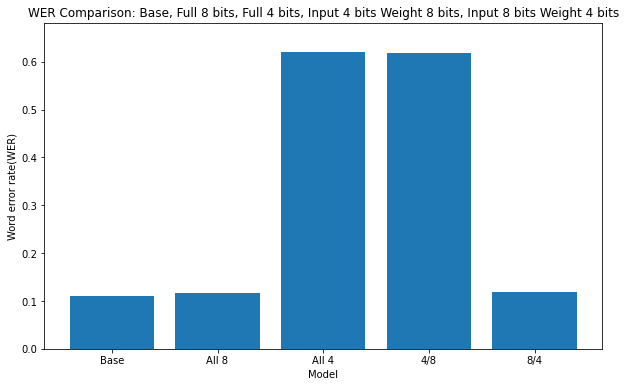

In [74]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_wer_result, eight_bits_all_model_quantized_wer_result, total_wer_four_bits_all_model_quantized_wer_result, four_bits_input_eight_bits_weight_model_quantized_wer_result, eight_bits_input_four_bits_weight_model_quantized_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base, Full 8 bits, Full 4 bits, Input 4 bits Weight 8 bits, Input 8 bits Weight 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()